In [1]:
import os
import sys
import fnmatch
import pandas as pd
from os.path import isfile, join
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
#import magcolloids as mgc
from matplotlib.patches import Rectangle

#sys.path.insert(0, '../icenumerics')

#import icenumerics as ice

sys.path.insert(0, '../Scripts')
from importlib import reload  
import From_Cairo_to_Shakti as lattices
reload(lattices)

mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 75

mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "green", "purple", 
                                                    "orange", "royalblue", "limegreen", 
                                                    "blueviolet","darkorange", "tomato",
                                                    "red","black"])

# Vertex Count (theta)

In this script, I will generate the vertex count plot for each theta value. Then I will save the last frame information, to build the transfer of charge picture. 

In [2]:
data_directory = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-14.0"

After moving data to the server Magnetic, the new data directory is:

In [3]:
data_directory = "/media/Carol/Magnetic/Simulations/Cairo_lattice_PROJECT/Output_simulations/Output_Script-14.0"

In [4]:
def count_vertices(vrt, exp = 'Exp', column = "type", column1 = "coordination", time = "frame"):
    vrt_count = vrt.groupby([exp,time,column,column1]).count().iloc[:,0].to_frame("number")

    vrt_count = vrt_count.reindex(pd.MultiIndex.from_product(
        [vrt_count.index.get_level_values(exp).unique(),
        vrt_count.index.get_level_values(time).unique(),
        vrt_count.index.get_level_values(column).unique(),
        vrt_count.index.get_level_values(column1).unique()]), fill_value = 0)

    total_vrt = vrt_count.groupby([exp,time,column1]).sum()
    array_coord = total_vrt.loc[vrt_count.index.get_level_values('frame')].number.values
    #array_coordT = np.tile(array_coord,9*10)# 9 times of charges and 10 experiments 
    print(len(vrt_count),len(array_coord))
    #array_coordT = np.tile(array_coord,round(int(len(vrt_count)/len(array_coord))))# 9 types of charges and 10 experiments 
    array_coordT = np.tile(array_coord[:2],int(len(vrt_count)/2))

    vrt_count["fraction"] = vrt_count.number / array_coordT
        
    return vrt_count

In [5]:
theta = np.linspace(np.pi/6, 5*np.pi/180, num= 15, endpoint=True, retstep=False, dtype=None, axis=0)
theta

array([0.52359878, 0.49243218, 0.46126559, 0.43009899, 0.3989324 ,
       0.36776581, 0.33659921, 0.30543262, 0.27426603, 0.24309943,
       0.21193284, 0.18076624, 0.14959965, 0.11843306, 0.08726646])

In [6]:
last_frame = []
for i in range(0,15):
    
    Lattices = []
    keys_Lattices = []
    for file in os.listdir(data_directory):
        if fnmatch.fnmatch(file, f"ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta{theta[i]}_exp*.dat"):
            print(file)
            Lattices.append(pd.read_csv(join(data_directory,file), sep = "\t", index_col = [0,1])) 
            keys_Lattices.append(theta[i])
    
    print(len(Lattices))
    #e = np.arange(0,10)
    e = np.arange(0,len(Lattices))
    Lattices_exp = pd.concat(Lattices, keys = e)
    print(len(Lattices_exp))

    Lattices_exp.index.names = ['Exp', 'frame', 'id']
    Lattices_exp

### Filter the vertices at the boundaries 

    First_frame = Lattices_exp.loc[0,0]

    d = 13 # Interparticle distance
    trap_sep_l = 10 # trap_sep parameter of the edge connecting 3 coordination and 4 coordination vertices
    s_l4 = d*np.sqrt(2)/2

    # <Generating lattice parameters depending on theta value>
    trap_sep_a, s_l3, a, l, plaquette_cte = lattices.lattice_parameters(theta[i], d, trap_sep_l, s_l4)

    x_min = 2*plaquette_cte
    y_min = plaquette_cte

    width = plaquette_cte*15
    hight = plaquette_cte*15

    x_max = x_min+width
    y_max = y_min+hight

    #print(x_min,x_max,y_min,y_max)

    #fig =plt.figure(figsize = (15,15))
    #ax = fig.add_subplot(111)

    #plt.plot(First_frame.x, First_frame.y , 'o')
    #ax.add_patch(Rectangle((x_min, y_min),width, hight,fc ='none', ec ='g',lw = 5))

    Ca = Lattices_exp.loc[(Lattices_exp['x']<x_max) & (Lattices_exp['x']>x_min)]
    Lattices_exp = Ca.loc[(Ca['y']<y_max) & (Ca['y']>y_min)]

    ### Classify vertices

    Lattices_exp["type"] = np.NaN

    # 4-fold vertices classification

    Lattices_exp.loc[Lattices_exp.charge==-4, "type"] = "Q = -4"
    Lattices_exp.loc[Lattices_exp.charge==-2, "type"] = "Q = -2"
    Lattices_exp.loc[Lattices_exp.charge==+2, "type"] = "Q = +2"
    Lattices_exp.loc[Lattices_exp.charge==+4, "type"] = "Q = +4"

    zeroq = Lattices_exp.charge==0

    dipole_magnitude = np.sqrt(Lattices_exp[zeroq].dx**2+Lattices_exp[zeroq].dy**2)

    Lattices_exp.loc[zeroq & (dipole_magnitude<1), "type"] = "Q = 0"
    Lattices_exp.loc[zeroq & (dipole_magnitude>2) , "type"] = "Q = 0"

    # 3-fold vertices classification

    Lattices_exp.loc[Lattices_exp.charge==+1, "type"] = "Q = +1"
    Lattices_exp.loc[Lattices_exp.charge==-1, "type"] = "Q = -1"
    Lattices_exp.loc[Lattices_exp.charge==+3, "type"] = "Q = +3"
    Lattices_exp.loc[Lattices_exp.charge==-3, "type"] = "Q = -3"

    Lattices_exp =Lattices_exp.query('coordination == 4 or coordination == 3')

    count_m = count_vertices(Lattices_exp)

    v_counts_m = count_m.groupby(["frame","type","coordination"]).mean()
    v_counts_m["err"] = count_m['fraction'].groupby(["frame","type","coordination"]).std()/np.sqrt(count_m['fraction'].groupby(["frame","type","coordination"]).count().values)

    #v_counts_m = v_counts_m[(v_counts_m != 0).all(1)]
    v_counts_m = v_counts_m.query('number != 0')
    v_counts_m['time'] = v_counts_m.index.get_level_values('frame')
    
    last_frame.append(v_counts_m.loc[2500])

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp37.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp7.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp24.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp28.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp47.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp30.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp12.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp42.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp35.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp5.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp0.0.dat
ACI_from_Cair

/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/carolina/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


225900 2510
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp33.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp44.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp20.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp14.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp12.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp4.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp38.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp16.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp2.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp46.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp37.0.dat


ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4612655880270728_exp1.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4612655880270728_exp6.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4612655880270728_exp30.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4612655880270728_exp19.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4612655880270728_exp22.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4612655880270728_exp21.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4612655880270728_exp37.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4612655880270728_exp44.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4612655880270728_exp48.0.dat
50
15060000
225900 2510
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp40.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4300989942414597

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp31.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp35.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp10.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp8.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp14.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp11.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp21.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp30.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp25.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp37.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3989324004558467_exp18.0.dat
ACI_from_Ca

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp17.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp2.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp26.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp21.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp48.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp42.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp6.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp19.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp28.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp49.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.3365992128846207_exp39.0.dat
ACI_from_Cai

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp7.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp47.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp14.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp44.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp17.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp10.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp43.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp46.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp1.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp32.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2742660253133946_exp23.0.dat
ACI_from_Cai

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp41.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp11.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp32.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp38.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp35.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp33.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp26.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp27.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp24.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp8.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.2119328377421686_exp20.0.dat
ACI_from_Ca

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp29.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp20.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp25.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp10.0.dat
50
15060000
225900 2510
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.14959965017094257_exp26.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.14959965017094257_exp2.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.14959965017094257_exp14.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.14959965017094257_exp39.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.14959965017094257_exp42.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.14959965017094257_exp35.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.149599

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp29.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp10.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp48.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp11.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp2.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp7.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp25.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp34.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp36.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp16.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp35.0.dat
A

In [7]:
last_frame

[                     number  fraction       err  time
 type   coordination                                  
 Q = +1 3             184.84  0.440095  0.002049  2500
 Q = +2 4              23.64  0.105067  0.002202  2500
 Q = +3 3               2.48  0.005905  0.000510  2500
 Q = +4 4               1.44  0.006400  0.000834  2500
 Q = -1 3             232.56  0.553714  0.001868  2500
 Q = -2 4               5.42  0.024089  0.001675  2500
 Q = -3 3               0.12  0.000286  0.000111  2500
 Q = 0  4             194.50  0.864444  0.002751  2500,
                      number  fraction       err  time
 type   coordination                                  
 Q = +1 3             210.20  0.467111  0.002229  2500
 Q = +2 4              14.66  0.065156  0.002183  2500
 Q = +3 3               3.00  0.006667  0.000561  2500
 Q = +4 4               0.62  0.002756  0.000552  2500
 Q = -1 3             236.76  0.526133  0.002005  2500
 Q = -2 4               7.96  0.035378  0.001550  2500
 Q = -3 3

In [8]:
LFrame = pd.concat(last_frame, keys = theta)

In [9]:
LFrame.index.names = ['theta', 'type', 'coordination']
LFrame.head(19)

number  fraction       err  time
theta    type   coordination                                  
0.523599 Q = +1 3             184.84  0.440095  0.002049  2500
         Q = +2 4              23.64  0.105067  0.002202  2500
         Q = +3 3               2.48  0.005905  0.000510  2500
         Q = +4 4               1.44  0.006400  0.000834  2500
         Q = -1 3             232.56  0.553714  0.001868  2500
         Q = -2 4               5.42  0.024089  0.001675  2500
         Q = -3 3               0.12  0.000286  0.000111  2500
         Q = 0  4             194.50  0.864444  0.002751  2500
0.492432 Q = +1 3             210.20  0.467111  0.002229  2500
         Q = +2 4              14.66  0.065156  0.002183  2500
         Q = +3 3               3.00  0.006667  0.000561  2500
         Q = +4 4               0.62  0.002756  0.000552  2500
         Q = -1 3             236.76  0.526133  0.002005  2500
         Q = -2 4               7.96  0.035378  0.001550  2500
         Q = -3 3               0.04  0.000089  0.000062  2500
         Q = -4 4               0.02  0.000089  0.000089  2500
         Q = 0  4             201.74  0.896622  0.002558  2500
0.461266 Q = +1 3             219.86  0.488578  0.002027  2500
         Q = +2 4               5.96  0.026489  0.001883  2500

In [10]:
LFrame.to_csv('charge_population_at_25mT_vs_theta.dat', sep = '\t')

Text(0.25, 0.85, 'At 25 mT')

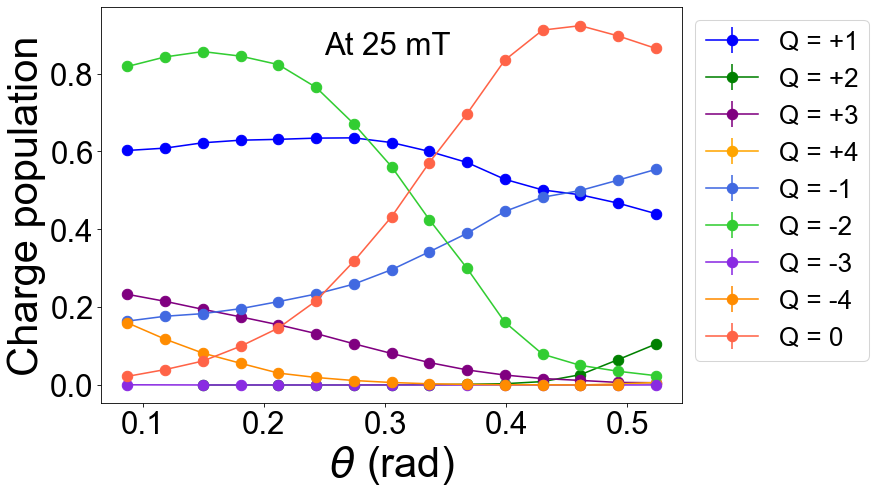

In [11]:
fig, ax1 = plt.subplots(figsize=(10,7))


for typ_m, mtype in LFrame.groupby('type'):
    
    ax1.errorbar(mtype.index.get_level_values('theta'), mtype["fraction"],yerr = mtype["err"], fmt ='-o', label = typ_m,markersize = 10)

    
ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)  

ax1.legend(fontsize = 25, bbox_to_anchor=(1, 1))
ax1.set_xlabel(r'$\theta$ (rad)', size = 40)
ax1.set_ylabel('Charge population', size = 40)
ax1.text(0.25, 0.85 ,'At 25 mT', size = 30)

In [12]:
LFrame3 = LFrame.query('coordination == 3')
LFrame4= LFrame.query('coordination == 4')

In [13]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 75

mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "navy", "tomato", 
                                                    "red", "plum", "blue", 
                                                    "navy", "tomato",
                                                    "red"]) 

Q = +1
Q = +3
Q = -1
Q = -3
Q = +2
Q = +4
Q = -2
Q = -4
Q = 0


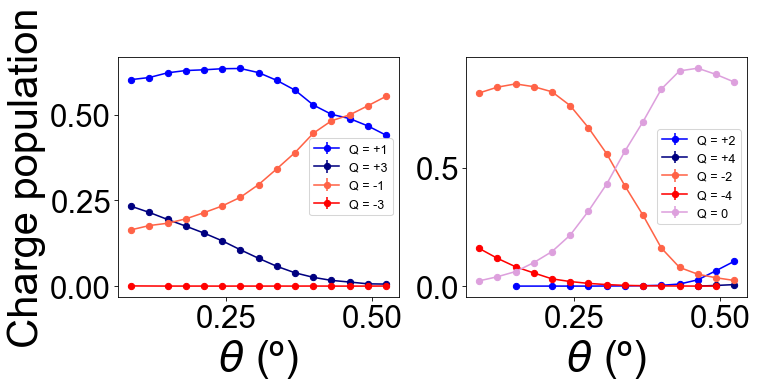

In [14]:
fig, ax = plt.subplots(1, 2,figsize=(10,5))

for typ_m, mtype in LFrame3.groupby('type'):
    print(typ_m)
    
    ax[0].errorbar(mtype.index.get_level_values('theta'), mtype["fraction"],yerr = mtype["err"],fmt = '-o', label = typ_m)

for typ_m, mtype in LFrame4.groupby('type'):
    print(typ_m)
    ax[1].errorbar(mtype.index.get_level_values('theta'), mtype["fraction"],yerr = mtype["err"], fmt ='-o',label = typ_m)

ax[0].tick_params(axis='y', labelsize=30)
ax[0].tick_params(axis='x', labelsize=30)  

ax[0].legend(fontsize = 12)
ax[0].set_xlabel(r'$\theta$ (º)', size = 40)
ax[0].set_ylabel('Charge population', size = 40)

ax[1].tick_params(axis='y', labelsize=30)
ax[1].tick_params(axis='x', labelsize=30)  

ax[1].legend(fontsize = 12)
ax[1].set_xlabel(r'$\theta$ (º)', size = 40)


plt.tight_layout()

In [15]:
LFrame['charge'] = LFrame.index.get_level_values('type')

In [16]:
def charge_value(row):
    
    value = int(row['charge'][-2:])
    return value

In [17]:
LFrame['charge'] = LFrame.apply (lambda row: charge_value(row) , axis=1)

In [18]:
LFrame

number  fraction       err  time  charge
theta    type   coordination                                          
0.523599 Q = +1 3             184.84  0.440095  0.002049  2500       1
         Q = +2 4              23.64  0.105067  0.002202  2500       2
         Q = +3 3               2.48  0.005905  0.000510  2500       3
         Q = +4 4               1.44  0.006400  0.000834  2500       4
         Q = -1 3             232.56  0.553714  0.001868  2500      -1
...                              ...       ...       ...   ...     ...
0.087266 Q = -1 3              68.94  0.164143  0.001880  2500      -1
         Q = -2 4             184.06  0.818044  0.003604  2500      -2
         Q = -3 3               0.24  0.000571  0.000160  2500      -3
         Q = -4 4              35.94  0.159733  0.003481  2500      -4
         Q = 0  4               5.00  0.022222  0.001448  2500       0

[118 rows x 5 columns]

In [19]:
LFrame['fraction*charge'] = LFrame['fraction']*LFrame['charge']
LFrame

number  fraction       err  time  charge  \
theta    type   coordination                                             
0.523599 Q = +1 3             184.84  0.440095  0.002049  2500       1   
         Q = +2 4              23.64  0.105067  0.002202  2500       2   
         Q = +3 3               2.48  0.005905  0.000510  2500       3   
         Q = +4 4               1.44  0.006400  0.000834  2500       4   
         Q = -1 3             232.56  0.553714  0.001868  2500      -1   
...                              ...       ...       ...   ...     ...   
0.087266 Q = -1 3              68.94  0.164143  0.001880  2500      -1   
         Q = -2 4             184.06  0.818044  0.003604  2500      -2   
         Q = -3 3               0.24  0.000571  0.000160  2500      -3   
         Q = -4 4              35.94  0.159733  0.003481  2500      -4   
         Q = 0  4               5.00  0.022222  0.001448  2500       0   

                              fraction*charge  
theta    type   coordination                   
0.523599 Q = +1 3                    0.440095  
         Q = +2 4                    0.210133  
         Q = +3 3                    0.017714  
         Q = +4 4                    0.025600  
         Q = -1 3                   -0.553714  
...                                       ...  
0.087266 Q = -1 3                   -0.164143  
         Q = -2 4                   -1.636089  
         Q = -3 3                   -0.001714  
         Q = -4 4                   -0.638933  
         Q = 0  4                    0.000000  

[118 rows x 6 columns]

In [20]:
sum_df = LFrame.groupby(['theta','coordination']).sum()

In [21]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue","red"])

In [24]:
sum_df['theta_deg'] = sum_df.index.get_level_values('theta')*180/np.pi

Text(0, 0.5, '$\\sum_{q} n_{z=3,4}q$')

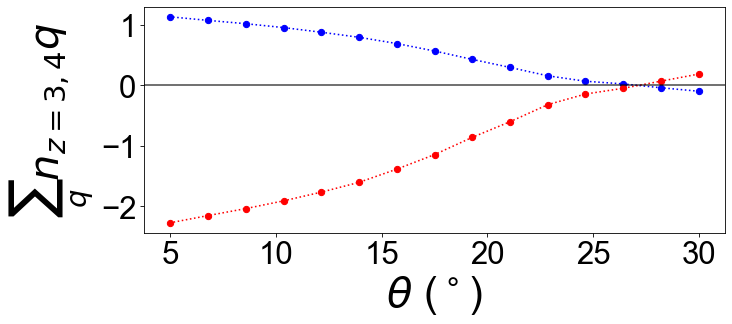

In [37]:
fig, ax = plt.subplots(1, 1,figsize=(10,4))


for typ_m, mtype in sum_df.groupby(['coordination']):
    
    plt.plot(mtype['theta_deg'], mtype['fraction*charge'],':o', label = typ_m)

plt.yticks(fontsize=30, ticks=[-2,-1,0,1])
plt.tick_params(axis='x', labelsize=30)  
#plt.legend(title = 'lattice coordination', fontsize = 15, title_fontsize = 15)
#plt.legend(title = 'lattice coordination', fontsize = 25, bbox_to_anchor=(1, 1), title_fontsize = 20)
plt.axhline(y=0, color='black',alpha = 0.7, linestyle='-')
plt.xlabel(r'$\theta$ ($^\circ$)', size = 40)
plt.ylabel(r'$\sum_{q} n_{z=3,4}q$', size = 40)

In [33]:
sum_df.to_csv('charge_transfer_vs_theta.dat', sep='\t')

In [38]:
sum_df

number  fraction       err   time  charge  \
theta    coordination                                              
0.523599 3              420.0       1.0  0.004538  10000       0   
         4              225.0       1.0  0.007463  10000       4   
0.492432 3              450.0       1.0  0.004858  10000       0   
         4              225.0       1.0  0.006932  12500       0   
0.461266 3              450.0       1.0  0.004467  10000       0   
         4              225.0       1.0  0.006531  12500       0   
0.430099 3              450.0       1.0  0.004340  10000       0   
         4              225.0       1.0  0.006097  10000      -4   
0.398932 3              420.0       1.0  0.005430  10000       0   
         4              225.0       1.0  0.007358  10000      -4   
0.367766 3              435.0       1.0  0.005247  10000       0   
         4              225.0       1.0  0.007775  10000      -4   
0.336599 3              420.0       1.0  0.006594  10000       0   
         4              225.0       1.0  0.009070  10000      -4   
0.305433 3              420.0       1.0  0.006385  10000       0   
         4              225.0       1.0  0.007879  10000      -4   
0.274266 3              420.0       1.0  0.006044  10000       0   
         4              225.0       1.0  0.007748  10000      -4   
0.243099 3              450.0       1.0  0.006868  10000       0   
         4              225.0       1.0  0.008802  10000      -4   
0.211933 3              435.0       1.0  0.007792  10000       0   
         4              225.0       1.0  0.007681  10000      -4   
0.180766 3              450.0       1.0  0.007706  10000       0   
         4              225.0       1.0  0.008394   7500      -6   
0.149600 3              435.0       1.0  0.007833  10000       0   
         4              225.0       1.0  0.006910  10000      -4   
0.118433 3              420.0       1.0  0.007254   7500       3   
         4              225.0       1.0  0.008446   7500      -6   
0.087266 3              420.0       1.0  0.007541  10000       0   
         4              225.0       1.0  0.008532   7500      -6   

                       fraction*charge  theta_deg  
theta    coordination                              
0.523599 3                   -0.096762  30.000000  
         4                    0.187556  30.000000  
0.492432 3                   -0.039289  28.214286  
         4                    0.070222  28.214286  
0.461266 3                    0.024533  26.428571  
         4                   -0.048000  26.428571  
0.430099 3                    0.068711  24.642857  
         4                   -0.142933  24.642857  
0.398932 3                    0.158667  22.857143  
         4                   -0.319289  22.857143  
0.367766 3                    0.297839  21.071429  
         4                   -0.601956  21.071429  
0.336599 3                    0.430571  19.285714  
         4                   -0.860622  19.285714  
0.305433 3                    0.569333  17.500000  
         4                   -1.146489  17.500000  
0.274266 3                    0.693048  15.714286  
         4                   -1.387378  15.714286  
0.243099 3                    0.796622  13.928571  
         4                   -1.606044  13.928571  
0.211933 3                    0.880460  12.142857  
         4                   -1.768356  12.142857  
0.180766 3                    0.957333  10.357143  
         4                   -1.912533  10.357143  
0.149600 3                    1.021517   8.571429  
         4                   -2.040356   8.571429  
0.118433 3                    1.076667   6.785714  
         4                   -2.156267   6.785714  
0.087266 3                    1.135333   5.000000  
         4                   -2.275022   5.000000